## **Business Problem Undeerstanding**

**Context**

Industri pariwisata adalah salah satu sektor pendatapan terbesar suatu Negara, tak jarang pada suatu Kota pendapatan masyarakatnya hanya mengandalkan dari sektor pariwisata. Salah satu bidangnya adalah perhotelan. Namun hotel sering mengalami kerugian pendapatan karena pelanggan tiba-tiba membatalkan pemesanan kamar mereka sehingga kamar mereka menjadi kosong. Sebagai Data Scientist yang baru direkrut oleh sebuah hotel bintang 5, kita akan memprediksi kecendrungan pelanggan apakah akan menginap pada hotel kita atau tidak menginap melalui fitur-fitur yang sudah tersedia. Prediksi ini akan membantu divisi marketing dan divisi manajerial hotel untuk lebih bisa meningkatkan pendapatan dan menjaga nama baik hotel tersebut.

Target:<br>
0: Pelanggan tidak membatalkan pesanan (menginap)<br>
1: Pelanggan membatalkan pesanan (tidak menginap)

**Problem Statement:**

Proses pembatalan bisa merugikan hotel, karena kamar tidak jadi terjual. Proses pembatalan yang paling merugikan adalah dengan cara No-Show.

Ketika hotel mendapatkan customer yang melakukan pembatalan pada menit akhir, hotel tidak bisa melakukan apapun kecuali menjual kamar dengan harga yang jauh lebih rendah, dikarenakan hotel sudah mengeluarkan biaya untuk melakukan penyiapan kamar. Jadi saat hotel menjual kamar dengan harga yang jauh lebih rendah peluang untuk mendapatkan revenue yang maksimal sangatlah minim.

**Goals:**

Maka berdasarkan permasalahan tersebut, hotel ingin memiliki kemampuan untuk memprediksi kemungkinan apakah seorang customer akan melakukan pembatalan pesanan atau tidak.

Prediksi tersebut dapat membantu hotel untuk mendapatkan revenue maksimal dan dapat menjaga reputasi baik hotel. Selain itu dengan kita tahu customer mana yang akan melakukan pembatalan pesanan atau tidak, kita dapat melakukan penawaran eksklusif kepada potential customer untuk mendapatkan pendapatan tambahan.

**Analytic Approach:**

Jadi yang akan kita lakukan adalah menganalisa data untuk menemukan pola yang membedakan customer yang akan melakukan pembatalan pesanan dan yang tidak membatalkan pesanan.

Kemudian kita akan membangun model klasifikasi yang akan membantu hotel untuk dapat memprediksi probabilitas seorang customer yang membatalkan pesanannya atau tidak.

**Metric Evaluation**<br>
Rata-rata harga 1 malam di Portugal https://www.budgetyourtrip.com/hotels/portugal-PT<br>
Besaran diskon untuk last minute sell https://www.nerdwallet.com/article/travel/is-it-cheaper-to-book-hotel-last-minute<br>
Disini kita juga mengasumsikan bahwa hotel sedang on season dimana hotel full booked.

Type 1 Error: False Positive<br>
Konsekuensi: Revenue yang diperoleh tidak maksimal dikarenakan kita salah memprediksi customer yang berpotensial untuk menginap.<br>
Tindakan : Disini menagapa revenue yang diperoleh tidak maksimal dikarenakan kita akan menjual kamar dengan harga rendah yaitu diskon 13% dikarenakan tidak ada info dari customer tersebut. Dan diasumsikan bahwa tidak ada lagi kamar kosong karena sedang on-season<br>
Loss revenue: $100 x 13% = $13

Type 2 Error: False Negative<br>
Konsekuensi: Kehilangan pendapatan akibat kamar kosong.<br>
Loss revenue: $100

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi kehilangan pendapatan untuk Hotel. Jadi kita ingin menekan False Negative sekecil mungkin untuk mendapatkan True Positive yang besar.

## **Data Understanding**

Note:
- Sebagian besar fitur bersifat kategori (Nominal, Ordinal, Binary)
- Setiap baris data merepresentasikan informasi seorang customer yang melakukan pemesanan dimasa lalu

### Attribute Information

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| country | Object | Country of origin. |
| market_segment | Object | Market segment designation |
| previous_cancellations | Integer | Number of previous bookings that were cancelled by the customer prior to the current booking. |
| booking_changes | Integer | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type | Object | Indication on if the customer made a deposit to guarantee the booking.  |
| Days_in_waiting_list | Integer | Number of days the booking was in the waiting list before it was confirmed to the customer. |
| customer_type | Object | Type of booking. |
| reserved_room_type | Object | Code of room type reserved. Code is presented instead of designation for anonymity reasons.|
| required_car_parking_spaces | Integer | Number of car parking spaces required by the customer. |
| total_of_special_requests | Integer | Number of special requests made by the customer (e.g. twin bed or high floor).|
| is_canceled | Integer | Value indicating if the booking was canceled (1) or not (0). |

In [2]:
# Library

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi
from sklearn.impute import KNNImputer # regresi KKN

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier         
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier 
from xgboost.sklearn import XGBClassifier  

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# imbalance
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import make_scorer, fbeta_score

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# other metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, PrecisionRecallDisplay, RocCurveDisplay, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor

# set max columns
pd.set_option('display.max_columns', None)

## **Load Dataset**

In [3]:
df = pd.read_csv('data_hotel_booking_demand.csv')

df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Pada data hotel booking demand terdapat 83.573 baris dan memiliki 11 kolom

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


## **Data Cleaning**

Ada beberapa data yang kosong dibeberapa fitur/kolom, maka kita akan memperbaiki semua datanya dan membuatnya menjadi siap pakai untuk melakukan analisa terhadap masalahnya dan juga pembuatan model machine learningnya.

In [5]:
df.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

Ada 351 data yang tidak terisi pada kolom country, kita akan melakukan pengisian pada kolom tersebut dengan cara impute pada proses preprocessing.

In [6]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'], data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[OMN, IRN]"
1,market_segment,object,0,0.00,8,"[Complementary, Undefined]"
2,previous_cancellations,int64,0,0.00,15,"[2, 19]"
3,booking_changes,int64,0,0.00,19,"[0, 9]"
4,deposit_type,object,0,0.00,3,"[No Deposit, Non Refund]"
5,days_in_waiting_list,int64,0,0.00,115,"[13, 207]"
6,customer_type,object,0,0.00,4,"[Transient-Party, Group]"
7,reserved_room_type,object,0,0.00,10,"[B, E]"
8,required_car_parking_spaces,int64,0,0.00,5,"[8, 0]"
9,total_of_special_requests,int64,0,0.00,6,"[1, 5]"


In [7]:
df.shape

(83573, 11)

In [8]:
# melihat apakah ada data duplikat atau tidak
df.duplicated().sum()

73371

Kita akan melakukan drop pada data duplicate dikarenakan supaya tidak terjadinya overfitting pada saat akan dilakukannya modeling 

In [9]:
# melakukan drop pada data yang duplikat
df = df.drop_duplicates()

In [10]:
df.shape

(10202, 11)

Merubah value Undefined pada market segment menjadi missing value supaya kita bisa ganti menggunakan simple imputer dengan estimator most_frequent

In [11]:
df['market_segment'].unique()

array(['Offline TA/TO', 'Online TA', 'Direct', 'Groups', 'Corporate',
       'Complementary', 'Aviation', 'Undefined'], dtype=object)

In [12]:
df = df.replace('Undefined', np.nan)

In [13]:
df.isna().sum()

country                        118
market_segment                   1
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

Disini dapat dilihat bahwa replace undefined menjadi missing value sudah terganti, terlihat bahwa pada kolom market_segment sudah memiliki 1 missing values

In [14]:
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Sekarang data sudah siap untuk digunakan

## **EDA**

Sebelum kita mulai dengan Exploratory Data Analysis (EDA), ada baiknya membedakan kolom mana yang kategori dan mana yang numerik. Hal ini berguna untuk menentukan jenis visualisasi yang dapat dilakukan.

Dapat kita lihat bahwa ada 11 kolom yang memuat 5 fitur kategorikal dan 6 fitur numerik.

In [15]:
# memisahkan kolom berdasarkan typenya(numerik)
df_numerik = df.drop(columns='is_canceled', axis=1)

In [16]:
df_numerik = df_numerik.describe().columns
df_numerik

Index(['previous_cancellations', 'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [17]:
# memisahkan kolom berdasarkan typenya(object)
df_cat = df.drop(columns='country', axis=1)

In [18]:
df_cat = df_cat.describe(include='object').columns
df_cat

Index(['market_segment', 'deposit_type', 'customer_type',
       'reserved_room_type'],
      dtype='object')

**Check Imbalance Data**

Kita akan melihat nilai dari kolom yang sudah kita targetkan (is_canceled) apakah terdapat perbedaan proporsi yang signifikan antara valuenya. Karena jika ternyata salah satu nilai pada kolom memiliki perbedaan yang signifikan, akan kita kategorikan sebagai imbalance data yang dimana akan berpengaruh terhadap model kita nanti

In [19]:
df['is_canceled'].value_counts()

0    7788
1    2414
Name: is_canceled, dtype: int64

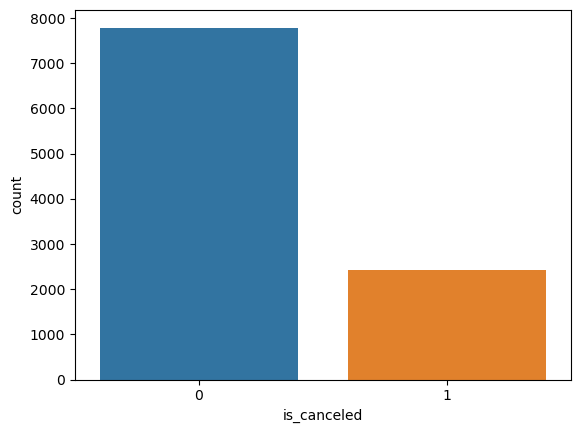

In [20]:
sns.countplot(data=df, x='is_canceled');

In [21]:
(pd.crosstab(index=df['is_canceled'], columns='Proportion (%)', normalize=True)*100).round(2)

col_0,Proportion (%)
is_canceled,
0,76.34
1,23.66


Dari pada grafik dan tabel di atas, kita dapat memastikan bahwa data kita imbalance, karena mayoritas data diatas 75%.

Disini kita akan melakukan beberapa tahap proses untuk data imbalance, yaitu:

1. Class Weight: Adalah parameter yang digunakan dalam beberapa algoritma machine learning untuk mengatasi data imbalance dalam dataset. class_weight dapat digunakan untuk memberikan bobot yang berbeda pada kelas-kelas target dalam perhitungan fungsi loss atau dalam proses pembelajaran.

2. Oversampling: Guna dari oversampling bertujuan untuk meningkatkan jumlah sampel dalam kelas minoritas agar seimbang dengan kelas mayoritas. Dengan meningkatkan jumlah sampel dalam kelas minoritas. Ada beberapa metode oversampling yang akan kita gunakan.

**Correlation**

In [22]:
df.corr()['is_canceled'].abs().sort_values(ascending=False)

C:\Users\arman\AppData\Local\Temp\ipykernel_8824\3890363523.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['is_canceled'].abs().sort_values(ascending=False)


is_canceled                    1.000000
required_car_parking_spaces    0.236280
previous_cancellations         0.077794
total_of_special_requests      0.072666
booking_changes                0.072628
days_in_waiting_list           0.032414
Name: is_canceled, dtype: float64

C:\Users\arman\AppData\Local\Temp\ipykernel_8824\2457145733.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='flare');


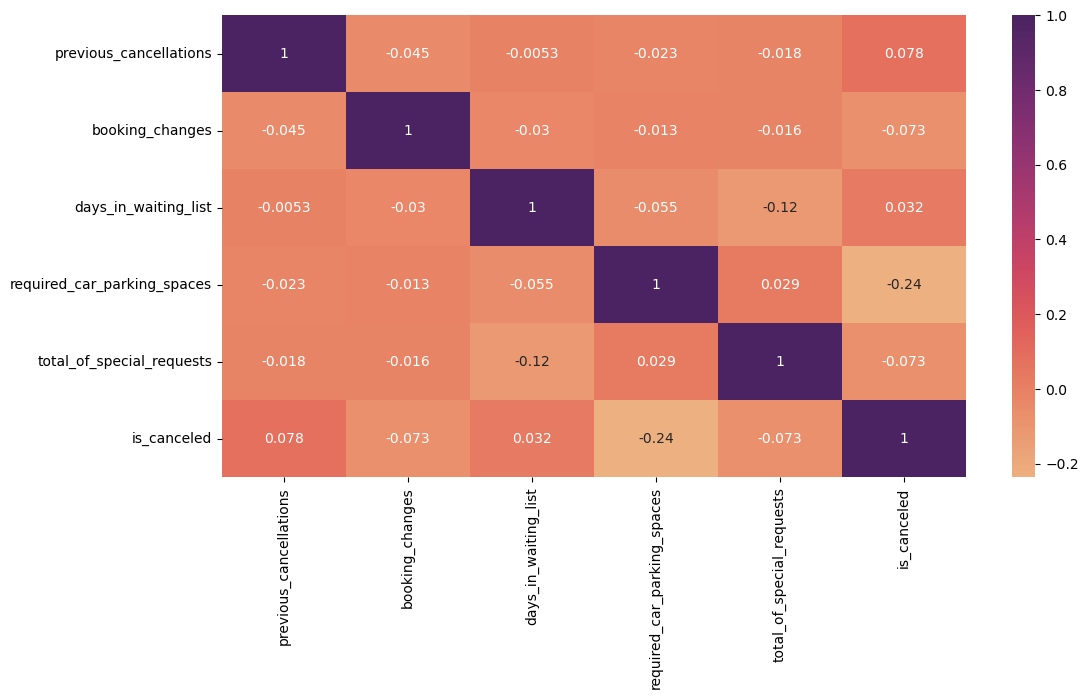

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='flare');

Dilihat pada hasil korelasi diatas, dapat kita simpulkan bahwa nilai korelasi tertinggi dimiliki oleh feature required_car_parking_spaces.

**Cancellation Percentage**

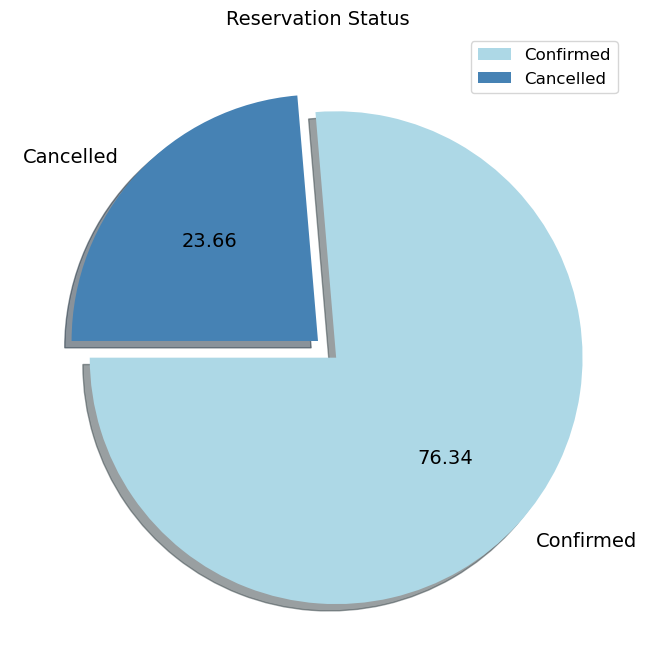

In [24]:
plt.figure(figsize= (14, 8))
plt.pie(df['is_canceled'].value_counts(),
                    autopct = '%.2f',
                    explode = [0.1,0],
                    labels = ['Confirmed', 'Cancelled'],
                    shadow = True, 
                    textprops = {'fontsize':14},
                    colors = ['lightblue', 'steelblue'],
                    startangle = 180
)
plt.title('Reservation Status', fontsize = 14)
plt.legend(fontsize = 12, loc = 'upper right')
plt.show()

Berdasarkan grafik di atas, 76.34% reservasi dikonfirmasi (menginap), dan 23.66% reservasi dibatalkan (tidak menginap) atau tamu memang tidak hadi di hotel.

**Top 10 Negara yang melakukan pembatalan dan tidak**

In [25]:
df.head(3)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0


In [26]:
# top 10 countries cancelled bookings
kelas_1 = df[df['is_canceled']==1]['country'].value_counts().reset_index().head(10)

kelas_1.columns = ['country', 'jumlah_customer']

kelas_1

,country,jumlah_customer
0,PRT,732
1,ESP,122
2,GBR,120
3,FRA,100
4,IRL,82
5,DEU,72
6,USA,63
7,ITA,61
8,BRA,60
9,BEL,50


In [27]:
# top 10 countries not cancelled bookings
kelas_0 = df[df['is_canceled']==0]['country'].value_counts().reset_index().head(10)

kelas_0.columns = ['country', 'jumlah_customer']

kelas_0

,country,jumlah_customer
0,PRT,1261
1,GBR,614
2,ESP,519
3,FRA,512
4,DEU,360
5,IRL,273
6,ITA,268
7,BEL,262
8,USA,247
9,NLD,230


Portugal, UK, Spain, France, dan Netherlands adalah Negara yang memiliki customer paling banyak menginap pada hotel kita. Namun ada hal menarik juga, Negara portugal menjadi Negara dengan customer terbanyak dengan melakukan pembatalan pesanan, hal ini mungkin bisa untuk menjadi pertimbangan kita untuk melakukan revisi pada aturan pembatalan pesanan yang sudah ada. Mengingat hotel kita pun berada pada Negara Portugal.

**Numerical Feature Analysis**

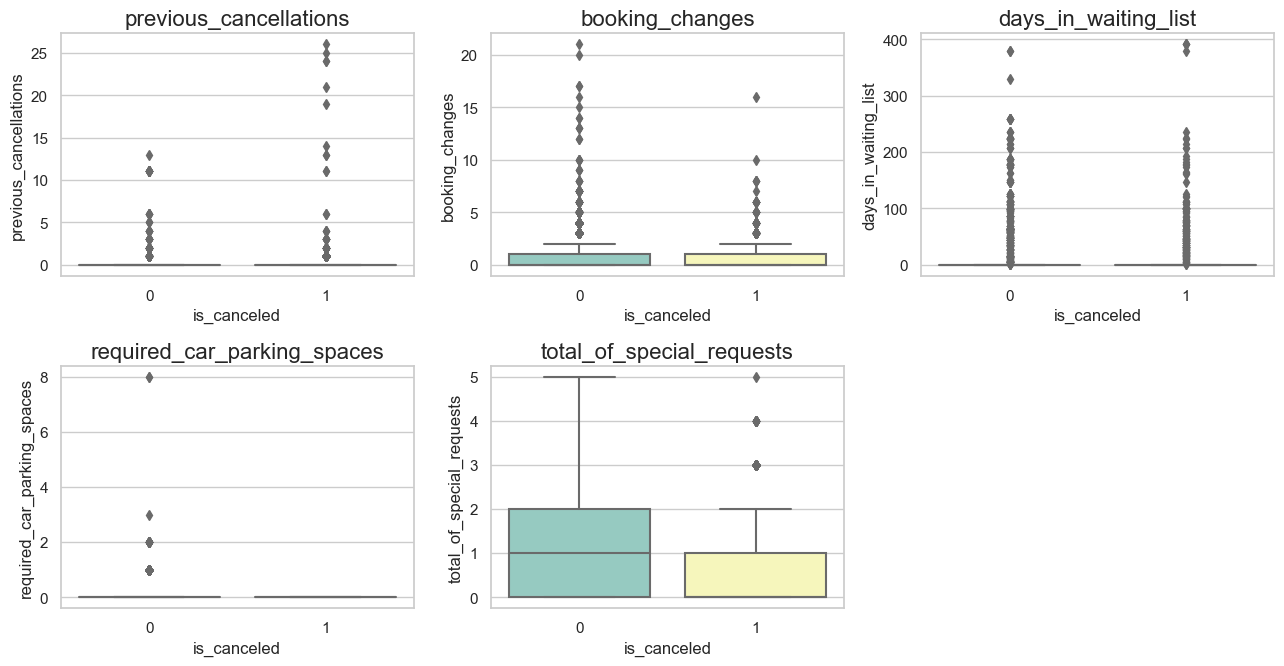

In [28]:
# meliihat data (kolom numerikal)
plt.figure(figsize=(13, 13), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1
    
for feature in df_numerik:
    ax = plt.subplot(4,3, plotnumber)
    sns.boxplot(x='is_canceled', y=feature, data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber += 1

Berdasarkan grafik diatas, kita dapat menyimpulkan bahwa pada kolom previous_cancellations customer yang sudah pernah melakukan pembatalan pemesanan sebelumnya cenderung melakukan pembatalan pemesanan lagi.

Sedangkan kalau distribusi booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_request kurang lebih sama antara target 0 dan 1. Dimana berarti kemungkinan features tersebut tidak mempengaruhi seorang customer akan melakukan pembatalan pemesanan atau tidak.

Disini kita pun tidak melakukan drop outliers, dikarenakan menurut kami data outliers tersebut dapat diwajarkan (bukan sebuah anomali data).

**Kategorical Feature Analysis**

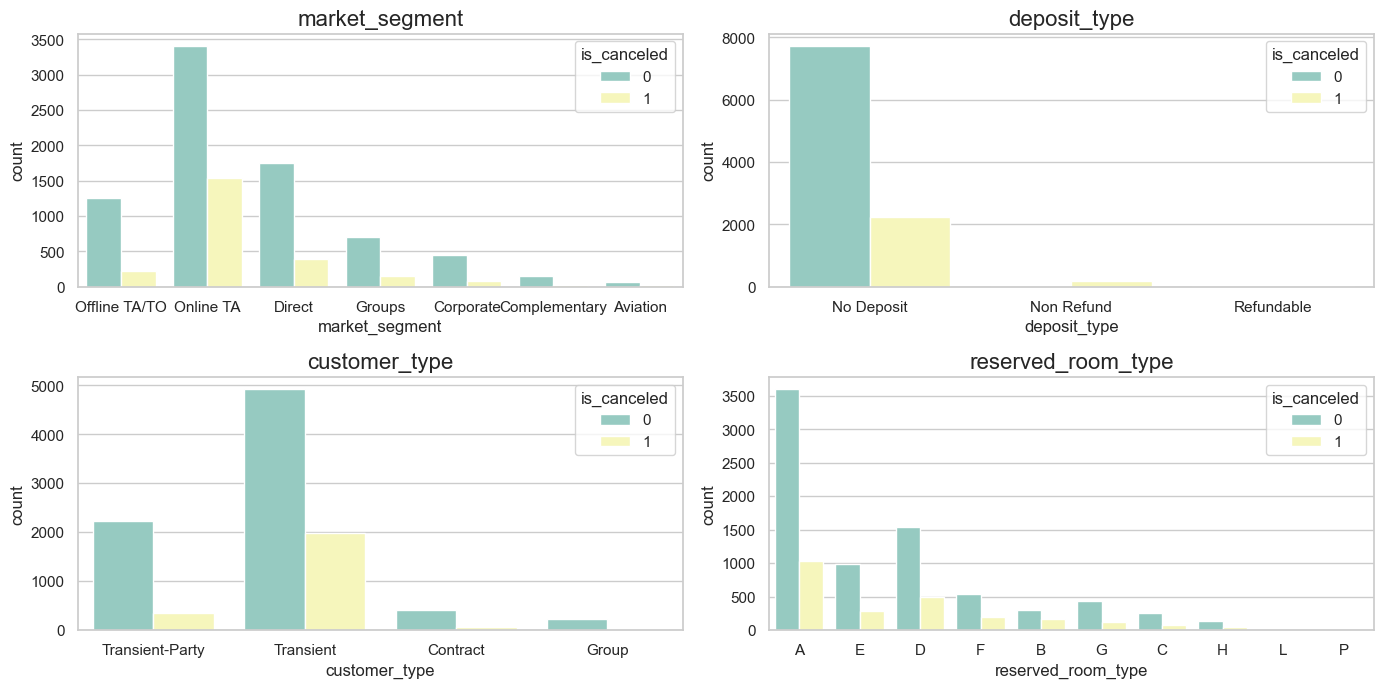

In [29]:
# prediksi calong nasabah berdasarkan kolom categorical
plt.figure(figsize=(14, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1

for feature in df_cat:
    # subplot (letak grafik)
    ax = plt.subplot(3, 2, plotnumber)
    
    # Harga rumah berdasarkan feature 
    sns.countplot(x = feature, data = df, hue='is_canceled')
    
    plt.xlabel(feature)
    plt.title(feature, fontsize=16)
    plt.tight_layout();
    
    plotnumber += 1

In [30]:
# membuat table untuk menunjukkan persentase proporsi data
for i in df.drop(columns=['country','previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests','is_canceled']).columns:
    relevent_experience_df = df.groupby(i)['is_canceled'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=[1.0], ascending=False))

is_canceled,0,1
market_segment,,
Online TA,0.689788,0.310212
Aviation,0.790123,0.209877
Direct,0.818352,0.181648
Groups,0.824292,0.175708
Complementary,0.839779,0.160221
Offline TA/TO,0.851552,0.148448
Corporate,0.856061,0.143939


is_canceled,0,1
deposit_type,,
Non Refund,0.107692,0.892308
Refundable,0.702128,0.297872
No Deposit,0.776506,0.223494


is_canceled,0,1
customer_type,,
Transient,0.712487,0.287513
Transient-Party,0.866329,0.133671
Contract,0.869023,0.130977
Group,0.913934,0.086066


is_canceled,0,1
reserved_room_type,,
P,NaN,1.000000
L,0.500000,0.500000
B,0.643172,0.356828
H,0.734375,0.265625
F,0.738889,0.261111
D,0.756121,0.243879
C,0.761765,0.238235
E,0.777603,0.222397
A,0.778474,0.221526


- Pada grafik market_segment, dapat dilihat bahwa mayoritas customer yang menginap maupun tidak menginap lebih banyak menggunakan Online Travel Agent (OTA). Dapat disimpulkan karena kemudahan dan kepraktisan membuat mayoritas customer menggunakan jasa travel agent.<br>
- Pada grafik deposit_type, mayoritas customer memesan kamar dengan menggunakan tipe tidak memakai deposit, baik dari customer yang menginap maupun yang tidak jadi menginap.<br>
- Jika pada grafik customer_type, mayoritas customer adalah customer yang sementara atau bisa disebut adalah customer yang baru ingin menginap pada hotel kita.<br>
- Pada grafik reserved_room_type, mayoritas customer melakukan reservasi untuk tipe kamar paling tinggi (tipe A).

## **Define X y**

- Variabel Independen (X): Variabel independen, juga dikenal sebagai variabel prediktor atau fitur, variabel yang digunakan untuk menjelaskan variabel dependen. Variabel independen merupakan variabel yang dianggap memiliki pengaruh atau keterkaitan dengan variabel dependen.<br><br>
- Variabel Dependen (y): Variabel dependen, juga dikenal sebagai variabel target atau variabel respons, adalah variabel yang ingin kita prediksi atau variabel yang dapat dijelaskan oleh variabel independen. Variabel dependen adalah variabel yang nilainya ingin kita pahami atau prediksi.

In [31]:
X = df.drop(columns='is_canceled')
y = df['is_canceled']

## **Data Splitting**

Data Splitting adalah proses membagi dataset menjadi subset yang berbeda untuk tujuan pelatihan (training), dan pengujian (testing). 
- Training Set: Training set adalah subset data yang digunakan untuk melatih model. Model menggunakan training set ini untuk mempelajari hubungan antara fitur-fitur dan variabel target. Semakin besar ukuran training set, semakin banyak informasi yang dapat digunakan oleh model dalam proses pembelajaran.<br><br>
- Test Set: Test set adalah subset data yang digunakan untuk menguji performa model yang telah dilatih dan disesuaikan parameternya pada data yang belum pernah dilihat sebelumnya. Test set memberikan perkiraan kinerja yang real dari model pada data. Performa model pada test set memberikan indikasi tentang seberapa baik model dapat digeneralisasi pada data yang belum pernah dilihat sebelumnya.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## **Preprocessing**

Pada preprocessing, kita mencoba untuk melakukan treatment pada fitur-fitur yang akan kita pakai untuk melakukan modeling.

1. Imputer: Imputer adalah sebuah teknik untuk mengisi nilai yang hilang (missing values) dalam dataset dengan nilai yang sesuai. Imputer dapat digunakan untuk mengisi nilai yang hilang dalam kolom numerik mauapun kategorikal. Ada beberapa macam imputer namun yang akan kita pakai adalah SimpleImputer.
    - SimpleImputer adalah salah satu imputer yang disediakan dalam library scikit-learn untuk mengisi nilai yang hilang dalam dataset. SimpleImputer mengisi nilai yang hilang dengan strategi sederhana seperti mean, median, most frequent atau nilai konstan yang ditentukan. Namun dalam kasus kita ini, kita akan menggunakan strategy most frequent dikarenakan kita ingin mencari mode atau modus dari feature country dan market_segment (kategorikal).<br><br>

2. Encoder: Adalah sebuah proses mengubah variabel kategorikal menjadi representasi numerik sehingga dapat digunakan dalam algoritma yang akan kita modeling. Dalam algoritma yang ingin kita pakai, banyak algoritma yang membutuhkan input numerik untuk melatih model dan membuat prediksi yang akurat. Oleh karena itu, feature kategorikal perlu diubah menjadi representasi numerik sebelum digunakan dalam algoritma-algoritma yang akan kita pakai untuk modeling.
    - OneHot Encoder: Salah satu metode encoding yang kita pakai. Setiap kategori dalam feature kategorikal akan diwakili oleh kolom biner baru. Disini feature yang akan kita OneHot Encoder adalah market_segment, deposit_type, customer_type, reserved_room_type. Mengapa kita memakai OneHot Encoder dikarenakan feature kategorikal yang kita punya memiliki banyak kategori yang tidak memiliki urutan yang signifikan.
    - Binary Encoder: Salah satu metode encoding yang akan kita pakai juga. Bedanya dengan menggunakan OneHot Encoder adalah Binary Encoder mampu menangani kategori yang lebih banyak dan juga tidak memiliki urutan. Kita menggunakan Binary Encoder untuk feature country, dikarenakan banyakanya nilai unik dari country mencapai 162.<br><br>

3. Scaling: Scaling adalah proses mengubah rentang nilai dari feature yang kita punya dalam dataset agar memiliki skala yang seragam. Tujuan dari scaling adalah untuk menghindari perbedaan skala yang signifikan antar feature-feature dalam dataset yang dapat mempengaruhi kinerja algoritma kita saat modeling. Ada beberapa metode scalling namun disini kita akan memakai metode RobustScaling.
    - RobustScaling: Metode scaling Robust digunakan untuk mengubah rentang nilai fitur dalam dataset dengan mempertahankan perbandingan relatif antara nilai dan mengurangi pengaruh outliers. Cara kerjanya adalah dengan cara mengurangi pengaruh outliers terhadap scaling data. Ini dlakukan dengan cara menggunakan median sebagai titik tengah alih-alih menggunakan rata-rata. Kita menggunakan RobustScaling untuk semua feature numerik yang kita punya, dikarenakan semua feature yang kita punya memiliki outliers, maka dari itu kita akan memilih RobustScaling.

- Imputer:<br>
    - simpleimputer: country, market_segment<br>
    
- Encoding:<br>
    - binary: country
    - onehot: market_segment, deposit_type, customer_type, reserved_room_type<br>

- Scaling:<br>
    - robust: all numerikal

In [33]:
simple_onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

simple_binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary', BinaryEncoder())
])

In [34]:
transformer = ColumnTransformer([
    ('simple_onehot', simple_onehot_pipeline, ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),
    ('simple_binary_pipeline', simple_binary_pipeline, ['country']),
    ('scaling', RobustScaler(), ['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests'])
], remainder='passthrough')

In [35]:
transformer_log = ColumnTransformer([
    ('simple_onehot', simple_onehot_pipeline, ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),
    ('simple_binary_pipeline', simple_binary_pipeline, ['country']),
    ('scaling', StandardScaler(), ['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests'])
], remainder='passthrough')

Disini kita membuat transformer tambahan dengan nama transformer_log untuk keperluan interpretasi kita, dengan scaling yang sudah terpilih pada hyperparameter yaitu standard scaler.

In [36]:
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('simple_onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'reserved_room_type']),
                                ('simple_binary_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary', BinaryEncoder())]),
                                 ['country']),
                                ('scaling', RobustScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests'])])

In [37]:
transformer_log.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('simple_onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'reserved_room_type']),
                                ('simple_binary_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary', BinaryEncoder())]),
                                 ['country']),
                                ('scaling', StandardScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests'])])

In [38]:
X_train_prep_log = transformer_log.transform(X_train)

In [39]:
# transform to x_train
X_train_prep = transformer.transform(X_train)

# transform to x_test
X_test_prep = transformer.transform(X_test)

In [40]:
# mengambil nama kolom simple_onehot
pipe_1 = transformer.transformers_[0][1].get_feature_names_out()

In [41]:
# mengambil nama kolom simple_binary_pipeline
pipe_2 = transformer.transformers_[1][1].get_feature_names_out()

In [42]:
# mengambil nama kolom scaling
pipe_3 = transformer.transformers_[2][1].get_feature_names_out()

In [43]:
# menggabungkan semua nama kolom
all_feature = list(pipe_1) + list(pipe_2) + list(pipe_3)

len(all_feature)


33

In [44]:
# hasil x_train_log
X_train_log = pd.DataFrame(X_train_prep_log, columns=all_feature)

In [45]:
# hasil x_train
X_train_prep_df = pd.DataFrame(X_train_prep, columns=all_feature)

## **Cross Validation**

Cross Validation adalah metode evaluasi yang digunakan untuk mengukur kinerja model secara objektif dan memperoleh estimasi yang lebih akurat tentang seberapa baik model kita akan berperforma pada data. Tujuan utamanya adalah untuk mencari alogirtma terbaik mana yang akan kita pilih untuk kita jadikan model berdasarkan score terbaiknya.

In [46]:
# logreg
logreg = LogisticRegression(random_state=42, class_weight='balanced')

# knn
knn = KNeighborsClassifier()

# decisiontree
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Bagging
bagging = BaggingClassifier(random_state=42, estimator=KNeighborsClassifier(n_neighbors=3))

# random forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# gradient boost
gboost = GradientBoostingClassifier(random_state=42)

# XGBoost
XGBoost = XGBClassifier(random_state=42)

Disini saya mencari algoritma terbaik menggunakan 7 algoritma. Dari 7 algoritma tersebut saya biarkan parameternya default.

1. Logistic Regression: Logistic regression adalah salah satu algoritma pembelajaran mesin yang digunakan untuk memodelkan hubungan antara variabel input (fitur) dan variabel output (kelas). Algoritma ini mengasumsikan hubungan antara variabel input dan output dapat dijelaskan dengan menggunakan fungsi logistik atau sigmoid.
2. KNeighborsClassifier: KNeighborsClassifier atau K-Nearest Neigihbors (KNN) adalah sebuah algoritma dengan teknik memberikan hasil prediksi berdasarkan kelas mayoritas dari beberapa pengamatan serupa atau tetangga terdekat. KNN bersifat non parametik, yang artinya tidak menghasilkan persamaan seperti linear regression.
3. DecisionTreeClassifier: Decission tree adalah algoritma yang mengarah pada keputusan. Sama halnya dengan KNN, decission tree bersifat non parametik dan digunakan untuk menjawab permasalahan yang sulit diselesaikan dengan model parametrik. Decission tree juga menghasilkan hasil yang lebih cepat dari KNN, fleksibel dan memiliki interpretability yang tinggi.
4. BaggingClassifier: Adalah salah satu metode ensemble learning yang menggabungkan bebereapa model pembelajaran mesin (base model) untuk menghasilkan model yang lebih kuat. Metode ini mengikuti pendekatan bootstrap aggregating (bagging) dimana sampel yang diambil secara acak dengan penggantian dari dataset pelatihan untuk membentuk subset dataset baru untuk setiap model. 
5. RandomForestClassifier: Random forest adalah metode pembelajaran ensemble untuk klasifikasi, yang artinya adalah beberapa model individu digabungkan untuk menghasilkan prediksi yang lebih baik daripada yang dapat dicapai oleh model tunggal (decission tree), random forest sendiri adalah sebuah algoritma yang terdiri dari beberapa decission tree yang disatukan. Dan random forest cucuk untuk training set yang mengalami overfitting.
6. GradientBoostingClassifier: Suatu metode ensemble learning yang digunakan untuk membangun model prediktif yang kuat. Secara umum, gradient boosting bekerja dengan menggabungkan sejumlah kecil model prediktif yang relatif sederhana, yang disebut 'weak learner' (misalnya, decission tree) menjadi model yang lebih kompleks dan kuat.
7. XGBoostClassifier: XGBoost bekerja dengna melatih sejumlah decission tree. Setiap tree dilatih pada subseb data, dan prediksi dari setiap pohon digabungkan untuk membentuk prediksi akhir. 

Disini kita juga memakai parameter class_weight pada algoritma logistic regression, decission tree, dan random forest. Guna dari parameter class_weight adalah untuk menyeimbangkan value mayoritas dan minoritas, dikarenakan data kita yang imbalance.

In [47]:
list_algo = [knn, tree, bagging, rf, gboost, XGBoost] #list algoritma yang akan kita tuning
list_score = []     # list kosong untuk score kita
list_mean = []      # list kosong untuk nilai mean kita
list_std = []       # list kosong untuk nilai std kita

for algo in list_algo:      # disini saya mencari algoritma terbaik menggunakan for loop

    # define algo
    model = algo        

    # define pipeline
    model_pipeline = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    cv_score = cross_val_score(
        estimator=model_pipeline,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='recall'
    )

    list_score.append(cv_score)
    list_mean.append(cv_score.mean())
    list_std.append(cv_score.std())

c:\Users\arman\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arman\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arman\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arman\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\arman\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Foun

In [48]:
df_cv = pd.DataFrame()
df_cv["Model"] = list_algo
df_cv["Score"] = list_score
df_cv["Mean"] = list_mean
df_cv["Std"] = list_std

df_cv.sort_values(by="Mean", ascending=False)

,Model,Score,Mean,Std
1,DecisionTreeClassifier(class_weight='balanced'...,"[0.3669250645994832, 0.35233160621761656, 0.40...",0.364059,0.023064
5,"XGBClassifier(base_score=None, booster=None, c...","[0.31007751937984496, 0.3134715025906736, 0.33...",0.338181,0.025326
3,RandomForestClassifier(class_weight='balanced'...,"[0.31007751937984496, 0.31088082901554404, 0.3...",0.327819,0.017316
0,KNeighborsClassifier(),"[0.3385012919896641, 0.27979274611398963, 0.29...",0.310187,0.022742
2,BaggingClassifier(estimator=KNeighborsClassifi...,"[0.2713178294573643, 0.25647668393782386, 0.29...",0.286388,0.019258
4,GradientBoostingClassifier(random_state=42),"[0.2971576227390181, 0.24870466321243523, 0.25...",0.265131,0.018602


Dapat dilihat bahwa hasil nilai tertinggi dimiliki oleh Decision Tree, dengna nilai 0.36 dan std 0.023 yang menunjukkan bahwa data cukup stabil.

## **Cross Validation Untuk Logistic Regression (Check Multicolinearity)**

Pada cross validation ini kita akan mencoba untuk melakukan pengecheckan terhadap multicolinearity untuk melihat performa logistic regression menggunakan VIF.

VIF adalah metrik yang digunakan untuk mengevaluasi multikolinearitas dalam model regresi. Multikolinearitas terjadi ketika ada korelasi tinggi antara dua atau lebih variabel independen dalam model regresi, yang dapat mengganggu interpretasi dan kestabilan model.

VIF mengukur seberapa banyak varian dari suatu variabel independen (feature) dipengaruhi oleh korelasi dengan variabel independen lain dalam model. Nilai VIF yang tinggi menunjukkan adanya multikolinearitas yang signifikan, yang dapat menyebabkan koefisien regresi menjadi tidak stabil dan sulit untuk diinterpretasikan.

Umumnya, aturan praktis adalah jika nilai VIF melebihi 5 atau 10, itu menunjukkan adanya multikolinearitas yang signifikan. Dalam kasus tersebut, langkah-langkah yang kita ambil adalah dengan menghapus variabel yang berkorelasi tinggi.

In [49]:
def calc_vif(x):

    vif = pd.DataFrame()
    vif['variables'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
        
    return (vif)

In [50]:
calc_vif(X_train_prep_df)

,variables,VIF
0,market_segment_Complementary,1.436784
1,market_segment_Corporate,2.120494
2,market_segment_Direct,6.074998
3,market_segment_Groups,3.175311
4,market_segment_Offline TA/TO,3.898055
5,market_segment_Online TA,12.127541
6,deposit_type_Non Refund,1.180346
7,deposit_type_Refundable,1.026813
8,customer_type_Group,1.450154
9,customer_type_Transient,14.051187


Dapat dilihat dari hasil vif, ada beberapa feature yang memiliki nilai diatas 4. Maka dari itu kita akan coba untuk menghapus satu persatu feature untuk melihat nilai dari feature lain.

Kita akan lakukan drop dengan nilai yang paling tinggi terlebih dahulu

In [51]:
# drop kolom dari nilai paling besar ['customer_type_Transient', 'market_segment_Online TA']

calc_vif(X_train_prep_df.drop(columns=['customer_type_Transient', 'market_segment_Online TA']))

,variables,VIF
0,market_segment_Complementary,1.053448
1,market_segment_Corporate,1.142188
2,market_segment_Direct,1.380080
3,market_segment_Groups,1.528457
4,market_segment_Offline TA/TO,1.376119
5,deposit_type_Non Refund,1.153506
6,deposit_type_Refundable,1.025613
7,customer_type_Group,1.038432
8,customer_type_Transient-Party,1.635719
9,reserved_room_type_B,1.089056


In [52]:
# feature (drop kolom yang didrop di multicollinearity)
X_train_prep_df_log = X_train_prep_df.drop(columns=['customer_type_Transient', 'market_segment_Online TA'])
X_train_prep_df_log.head()

,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient-Party,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.5
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.5


**Melihat CV score Logistic Regression**

In [53]:
list_score_log = []
list_model = []

cv_score_log = cross_val_score(
    estimator=logreg,
    X=X_train_prep_df_log,
    y=y_train,
    cv=5,
    scoring='recall'
)
list_score_log.append(cv_score_log)
list_model.append(logreg)

cv_log = pd.DataFrame()
cv_log["Model"] = list_model
cv_log["Score"] = list_score_log
cv_log["Mean"] = cv_score_log.mean()
cv_log["Std"] = cv_score_log.std()

cv_log

c:\Users\arman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

,Model,Score,Mean,Std
0,"LogisticRegression(class_weight='balanced', ra...","[0.7906976744186046, 0.7435233160621761, 0.774...",0.784046,0.024693


Dapat dilihat pada dataframe diatas bahwa nilai logistic regression adalah 0.78 dengan std 0.024.

**Membandingkan dataframe cross validation dan cross validation logreg**

In [54]:
display(df_cv, cv_log)

,Model,Score,Mean,Std
0,KNeighborsClassifier(),"[0.3385012919896641, 0.27979274611398963, 0.29...",0.310187,0.022742
1,DecisionTreeClassifier(class_weight='balanced'...,"[0.3669250645994832, 0.35233160621761656, 0.40...",0.364059,0.023064
2,BaggingClassifier(estimator=KNeighborsClassifi...,"[0.2713178294573643, 0.25647668393782386, 0.29...",0.286388,0.019258
3,RandomForestClassifier(class_weight='balanced'...,"[0.31007751937984496, 0.31088082901554404, 0.3...",0.327819,0.017316
4,GradientBoostingClassifier(random_state=42),"[0.2971576227390181, 0.24870466321243523, 0.25...",0.265131,0.018602
5,"XGBClassifier(base_score=None, booster=None, c...","[0.31007751937984496, 0.3134715025906736, 0.33...",0.338181,0.025326


,Model,Score,Mean,Std
0,"LogisticRegression(class_weight='balanced', ra...","[0.7906976744186046, 0.7435233160621761, 0.774...",0.784046,0.024693


## **Hyperparameter Tuning**

Dapat dilihat pada nilai mean diatas, nilai tertinggi dimiliki oleh algoritma Logistic Regression, maka dari itu kita akan mencoba tuning algoritma Logistic Regression.<br>
Parameter tuning mengacu pada artikel dibawah ini.<br>
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/<br>

Logistic regression adalah salah satu algoritma pembelajaran mesin yang digunakan untuk memodelkan hubungan antara variabel input (fitur) dan variabel output (kelas). Algoritma ini mengasumsikan hubungan antara variabel input dan output dapat dijelaskan dengan menggunakan fungsi logistik atau sigmoid.

Disini pula kita akan coba untuk mentuning resampling, dikarenakan data kita yang imbalance. Maka dari itu kita juga akan mencari resampling terbaik untuk data kita.

In [55]:
# membuat list_resampling

list_resampling = [RandomOverSampler(random_state=0), RandomUnderSampler(random_state=0), SMOTE(random_state=0), NearMiss()]

resampling = RandomOverSampler(random_state=0)

Resampling adalah teknik yang digunakan untuk memperoleh sampel ulang dari data yang ada. Tujuannya adalah untuk mengatasi masalah seperti data yang tidak balance (imbalance). Ada dua jenis resampling yang umum digunakan:

1. Oversampling: melibatkan peningkatan jumlah sampel pada kelas minoritas dalam dataset untuk mencapai data balance. Ada beberapa metode oversampling yang umum termasuk:
    - Random Oversampling: Menaikkan jumlah sampel pada kelas minoritas dengan menambahkan duplikat atau variasi dari sampel yang ada.
    - SMOTE (Synthetic Minority Over-sampling Technique): Membangun sampel sintetis baru pada kelas minoritas dengan mempertimbangkan tetangga-tetangga terdekat dari sample yang ada.<br><br>

2. Undersampling: Undersampling melibatkan pengurangan jumlah sampel pada kelas mayoritas untuk mencapai data balance. Beberapa metode undersampling yang umum termasuk:
    - Random Undersampling: Mengurangi jumlah sampel pada kelas mayoritas dengna menghapus sebagian sampel secara acak.
    - Nearmiss: Bekerja dengan mengidentifikasi sampel dari kelas mayoritas yang berdekatan dengan sampel dari kelas minoritas. Kemudian, beberapa dari sampel tersebut dihapus secara acak sehingga kelas mayoritas menjadi lebih seimbang dengan kelas minoritas.

In [56]:
hyperparam = {
    'modeling__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'modeling__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'modeling__C': [100, 10, 1.0, 0.1, 0.01],
    'prep__scaling': [RobustScaler(), MinMaxScaler(), StandardScaler()],
    'resampling' : list_resampling
}

model_pipe = Pipeline([
        ('resampling', resampling),
        ('prep', transformer), 
        ('modeling', logreg)])


gridsearch = GridSearchCV(
    estimator = model_pipe,
    param_grid=hyperparam,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

Pada coding diatas saya mencoba untuk mentuning algoritma Logistic Regression dengan 3 parameter, yaitu:

1. Solver: Parameter ini memilih algoritma yang digunakan untuk menyelesaikan masalah optimasi yang mendasari dalam logistic regression. Beberapa solver umum adalah 'liblinear', 'lbfgs', 'newton-cg', 'sag', dan 'saga'. Pilihan solver tergantung pada ukuran data, masalah yang dihadapi, dan kecepatan konvergensi yang diinginkan.

2. Penalty: Parameter ini mengontrol jenis regulasi yang digunakan dalam model. Nilai yang umum adalah 'l1' (L1 regularization), 'l2' (L2 regularization), atau 'none' (tanpa regulazation). Regulasi membantu mengurangi overfitting dengan menambahkan tambahan penalti pada koefisien model.

3. C: Parameter ini mengontrol kekuatan regulasi. Nilai yang lebih kecil memberikan regulasi yang lebih kuat, sedangkan nilai yang lebih besar memberikan regulasi yang lebih lemah. Nilai default adalah 1.0

Kita juga mencoba tuning untuk jenis scaling apa yang paling baik untuk data kita (robust scaling, min maxa scaling, standard scaling).

In [57]:
gridsearch.fit(X_train, y_train)

c:\Users\arman\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4350 fits failed out of a total of 6000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arman\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\arman\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\arman\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "c:\Users\

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('resampling',
                                        RandomOverSampler(random_state=0)),
                                       ('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('simple_onehot',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'customer_...
             param_grid={'modeling__C': [100, 10, 1.0, 0.1, 0.01],
                         'modeling__penalty': ['none', 'l1', 'l2',
                                               'elasticnet'],
                         'modeling__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                              'sag', 'saga'],
                         'prep__scaling': [RobustScaler(), MinMaxScaler(),
                                           StandardScaler()],
                         'resampling': [RandomOverSampler(random_state=0),
                                        RandomUnderSampler(random_state=0),
                                        SMOTE(random_state=0), NearMiss()]},
             scoring='recall')

In [58]:
df_grid = pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score')
df_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__C,param_modeling__penalty,param_modeling__solver,param_prep__scaling,param_resampling,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1053,0.074525,0.003020,0.025492,0.001490,0.01,l1,liblinear,StandardScaler(),RandomUnderSampler(random_state=0),"{'modeling__C': 0.01, 'modeling__penalty': 'l1...",1.000000,0.997409,0.992228,0.966321,0.981865,0.987565,0.012305,1
1077,0.202847,0.019037,0.030604,0.001319,0.01,l1,saga,StandardScaler(),RandomUnderSampler(random_state=0),"{'modeling__C': 0.01, 'modeling__penalty': 'l1...",0.899225,0.862694,0.821244,0.865285,0.891192,0.867928,0.027329,2
1045,0.084418,0.021188,0.026501,0.005347,0.01,l1,liblinear,RobustScaler(),RandomUnderSampler(random_state=0),"{'modeling__C': 0.01, 'modeling__penalty': 'l1...",0.891473,0.870466,0.818653,0.849741,0.886010,0.863269,0.026601,3
1052,0.195685,0.012290,0.030347,0.002700,0.01,l1,liblinear,StandardScaler(),RandomOverSampler(random_state=0),"{'modeling__C': 0.01, 'modeling__penalty': 'l1...",0.855297,0.805699,0.813472,0.857513,0.878238,0.842044,0.027793,4
1044,0.138400,0.017278,0.023011,0.004046,0.01,l1,liblinear,RobustScaler(),RandomOverSampler(random_state=0),"{'modeling__C': 0.01, 'modeling__penalty': 'l1...",0.863049,0.797927,0.810881,0.854922,0.857513,0.836859,0.026942,5


In [59]:
gridsearch.best_params_

{'modeling__C': 0.01,
 'modeling__penalty': 'l1',
 'modeling__solver': 'liblinear',
 'prep__scaling': StandardScaler(),
 'resampling': RandomUnderSampler(random_state=0)}

In [60]:
gridsearch.best_score_

0.9875647668393782

In [61]:
print('mean sebelum tuning: ', ((cv_log.loc[0, 'Mean'])*100).round(2))
print('std sebelum tuning: ', cv_log.loc[0, 'Std'])
print()
print('mean setelah tuning: ', (((gridsearch.best_score_)*100)).round(2))
print('std setelah tuning: ', df_grid.iloc[0, -2])

mean sebelum tuning:  78.4
std sebelum tuning:  0.024692794150793958

mean setelah tuning:  98.76
std setelah tuning:  0.012305017706775037


Dapat dilihat diatas bahwa hasil dari hyperparameter tuning kita mengalami peningkatan, yaitu dari 78.4% menjadi 98.76%. Selain nilai dari algoritma kita, kita mendapatkan parameter terbaik juga antara lain:
- untuk nilai C: 0.01
- penalty: 'l1'
- solver: 'liblinear'
- scaling: StandartScaler
- resampling: RandomUnderSampler

## **Predict To Test Set**

Kita akan melihat bagaimana performa algoritma kita saat di data test yang sudah kita siapkan.

**Sebelum Tuning**

In [62]:
model = logreg

# model
pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', model)
])

# model training
pipe_model.fit(X_train, y_train)

# model predicting test set
y_pred_benchmark = pipe_model.predict(X_test)

(recall_score(y_test, y_pred_benchmark)*100).round(2)

c:\Users\arman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


79.3

**Setelah Tuning**

In [63]:
# model
best_model = gridsearch.best_estimator_

# model training
best_model.fit(X_train, y_train)

# model predicting test set
y_pred_best = best_model.predict(X_test)

(recall_score(y_test, y_pred_best)*100).round(2)

93.58

In [64]:
print('Recall before tuning',(recall_score(y_test,y_pred_benchmark)*100).round(2))
print()
print('Recall before tuning',(recall_score(y_test,y_pred_best)*100).round(2))

Recall before tuning 79.3

Recall before tuning 93.58


Dapat dilihat nilai sebelum tuning pada data test set adalah 79.3%, dan nilai mengalami peningkatan setelah tuning menjadi 93.58%

## **Other Metrics**

Disini kita akan mengevaluasi metric kita.

### **Before Tuning**

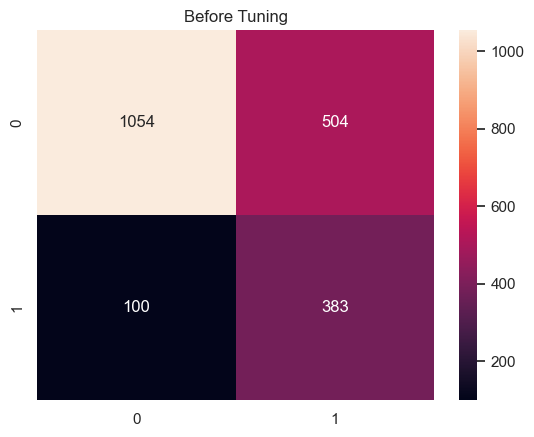

In [65]:
sns.heatmap(confusion_matrix(y_test, y_pred_benchmark), annot=True, fmt='.0f')
plt.title('Before Tuning');

Insights:

- True Positive (TP): Ada 383 prediksi yang benar diklasifikasikan sebagai kelas positif.
- True Negative (TN): Ada 1054 prediksi yang benar diklasifikasikan sebagai kelas negatif.
- False Positive (FP): Ada 504 prediksi yang salah diklasififkasikan sebagai kelas positif.
- False Negative (FN): Ada 100 prediksi yang salah diklasifikasikan sebagai kelas negatif.

Dari confusion matrix tersebut, dapat ditarik beberapa kesimpulan:

- Dengan proporsi threshold 50:50 menggunakan Logistic Regression model, model berhasil mengklasifikasikan 383 sampel sebagai kelas positif yang benar dan 1054 sampel sebagai kelas negatif yang benar
- Model salah mengklasifikasikan 504 sampel sebagai kelas positif padahal seharusnya kelas negatif.
- Model juga salah mengklasifikasikan 100 sampel kelas negatif padahal seharusnya positif.

In [66]:
# predict probabilities
y_pred_proba_before = pipe_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
y_pred_proba_before = y_pred_proba_before[:, 1]

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_before)

In [67]:
df_pr_curve_before = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'thresholds': list(thresholds) + [0]
}).sort_values('recall', ascending=False)

df_pr_curve_before.sort_values('recall', ascending=False)

,precision,recall,thresholds
0,0.236649,1.000000,7.859906e-07
23,0.239346,1.000000,7.014073e-04
2,0.236881,1.000000,2.331535e-05
3,0.236997,1.000000,6.277030e-05
4,0.237113,1.000000,1.932579e-04
...,...,...,...
1993,0.750000,0.006211,9.794696e-01
1994,1.000000,0.006211,9.858771e-01
1995,1.000000,0.004141,9.909553e-01
1996,1.000000,0.002070,9.997840e-01


Pada tabel diatas menunjukkan nilai precision, dan nilai recall berdasarkan besaran thresholds. Namun menggunakan data yang belum dituning

In [68]:
print(classification_report(y_test, y_pred_benchmark))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1558
           1       0.43      0.79      0.56       483

    accuracy                           0.70      2041
   macro avg       0.67      0.73      0.67      2041
weighted avg       0.80      0.70      0.73      2041



Insight:

1. Dari seluruh customer yang akan cancel maka sekitar sekitar 79% diprediksi dengan benar menggunakan model ini. hal ini bisa dilihat dari recallnya pada target 1 (cancel), dan model juga dapat menebak dengan benar untuk customer yang tidak melakukan cancel sebesar 43% dari seluruh customer yang memang tidak cancel, hal ini juga dilihat dari recall target 0 (tidak cancel).

2. Dari seluruh prediksi cancel dari model, model dapat mengidentifikasi sekitar 68% ketepatan prediksi target 1 (cancel) hal ini diambil dari precisionnya, dan dari seluruh prediksi tidak akan cancel akan diindentifikasi benar oleh model sekitar 91% pada target 0 (tidak cancel).

In [69]:
# membuat titik untuk dimana data kita berada
recall_threshold = [0.79]
precision_threshold = [0.43]

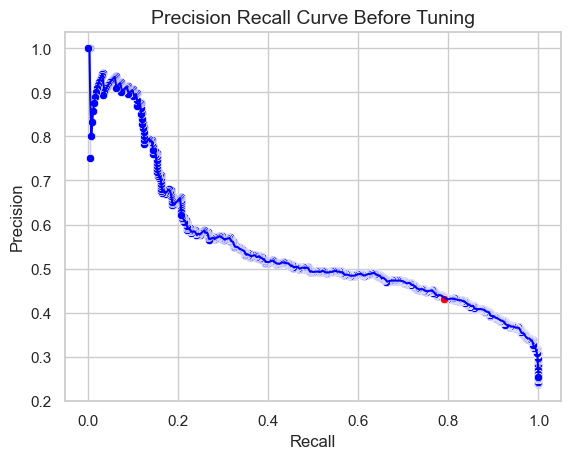

In [70]:
# Cara buat Precision Recall Curve manual

sns.lineplot(data=df_pr_curve_before, x='recall', y='precision', color='b')
sns.scatterplot(data=df_pr_curve_before, x='recall', y='precision', color='b')
sns.scatterplot(x=recall_threshold, y=precision_threshold, color='r')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve Before Tuning', size=14);

Insight:

- Dari grafik diatas dapat dilihat bahwa titik merah adalah dimana data kita berada, yaitu dengan nilai recall 0.79, nilai precision 0.43, dan dengan threshold 0.50. Namun sangat sulit untuk menentukan pada threshold berapa nilai terbaik yang kita butuhkan.

### **After Tuning**

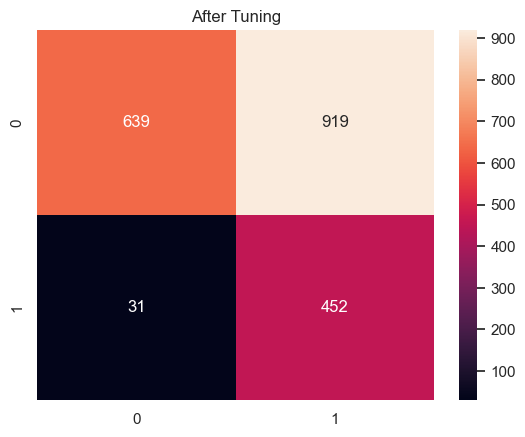

In [71]:
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='.0f')
plt.title('After Tuning');

Insights:

- True Positive (TP): Ada 452 prediksi yang benar diklasifikasikan sebagai kelas positif.
- True Negative (TN): Ada 639 prediksi yang benar diklasifikasikan sebagai kelas negatif.
- False Positive (FP): Ada 919 prediksi yang salah diklasififkasikan sebagai kelas positif.
- False Negative (FN): Ada 31 prediksi yang salah diklasifikasikan sebagai kelas negatif.

Dari confusion matrix tersebut, dapat ditarik beberapa kesimpulan:

- Dengan proporsi threshold 50:50 menggunakan Logistic Regression model, model berhasil mengklasifikasikan 452 sampel sebagai kelas positif yang benar dan 639 sampel sebagai kelas negatif yang benar
- Model salah mengklasifikasikan 919 sampel sebagai kelas positif padahal seharusnya kelas negatif.
- Model juga salah mengklasifikasikan 31 sampel kelas negatif padahal seharusnya positif.

In [72]:
# predict probabilities
y_pred_proba_after = best_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
y_pred_proba_after = y_pred_proba_after[:, 1]

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_after)

In [73]:
df_pr_curve_before = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'thresholds': list(thresholds) + [0]
}).sort_values('precision', ascending=False)

df_pr_curve_before.sort_values('recall', ascending=False)

,precision,recall,thresholds
0,0.236649,1.000000,0.004613
104,0.259957,1.000000,0.100722
106,0.260658,1.000000,0.100845
107,0.260799,1.000000,0.101335
108,0.260940,1.000000,0.102042
...,...,...,...
596,0.595238,0.051760,0.650732
597,0.575000,0.047619,0.657611
598,0.523810,0.022774,0.658775
599,1.000000,0.004141,0.660292


Pada tabel diatas menunjukkan nilai precision, dan nilai recall berdasarkan besaran thresholds. Namun menggunakan data yang sudah dituning

In [74]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.95      0.41      0.57      1558
           1       0.33      0.94      0.49       483

    accuracy                           0.53      2041
   macro avg       0.64      0.67      0.53      2041
weighted avg       0.81      0.53      0.55      2041



Insight:

1. Dari seluruh customer yang akan cancel maka sekitar sekitar 94% diprediksi dengan benar menggunakan model ini. hal ini bisa dilihat dari recallnya pada target 1 (cancel), dan model juga dapat menebak dengan benar untuk customer yang tidak melakukan cancel sebesar 33% dari seluruh customer yang memang tidak cancel, hal ini juga dilihat dari recall target 0 (tidak cancel).

2. Dari seluruh prediksi cancel dari model, model dapat mengidentifikasi sekitar 41% ketepatan prediksi target 1 (cancel) hal ini diambil dari precisionnya, dan dari seluruh prediksi tidak akan cancel akan diindentifikasi benar oleh model sekitar 95% pada target 0 (tidak cancel).

In [75]:
# membuat titik untuk dimana data kita berada

recall_threshold_after = [0.94]
precision_threshold_after = [0.33]

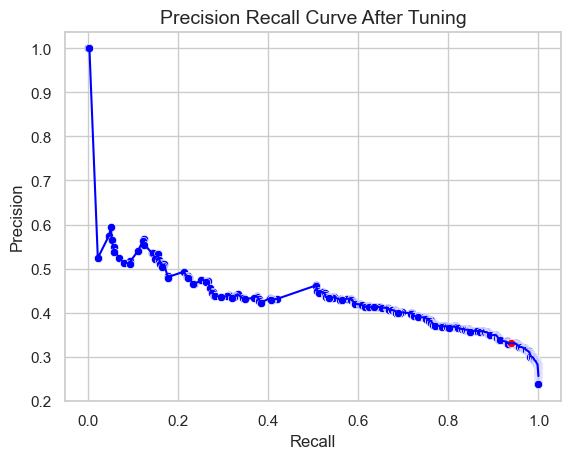

In [76]:
# Cara buat Precision Recall Curve manual

sns.lineplot(data=df_pr_curve_before, x='recall', y='precision', color='b')
sns.scatterplot(data=df_pr_curve_before, x='recall', y='precision', color='b')
sns.scatterplot(x=recall_threshold_after, y=precision_threshold_after, color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve After Tuning', size=14);

Insight:

- Dari grafik diatas dapat dilihat bahwa titik merah adalah dimana data kita berada, yaitu dengan nilai recall 0.94, nilai precision 0.33, dan dengan threshold 0.50. Namun sangat sulit untuk menentukan pada threshold berapa nilai terbaik yang kita butuhkan.

**Perbandingan confusion matrix sebelum tuning dan sesudah tuning**

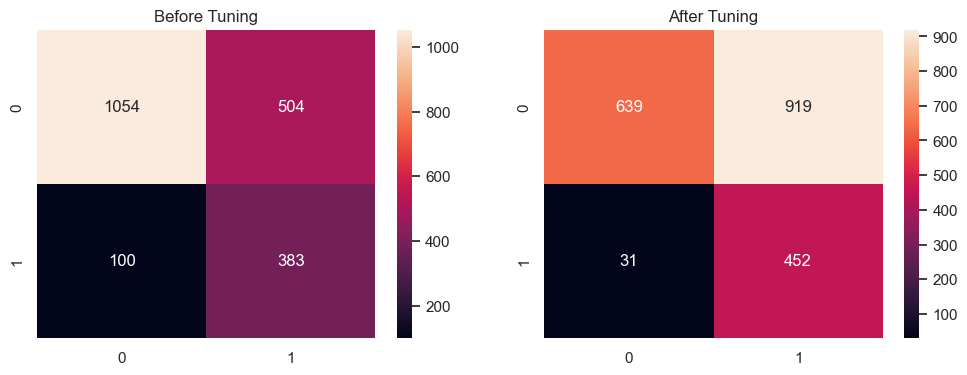

In [77]:
plt.figure(figsize=(12,4))

# plt.subplot(1,2,1)
# sns.heatmap(confusion_matrix(y, y_test), annot=True, fmt='.0f')
# plt.title('Before ML')

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_benchmark), annot=True, fmt='.0f')
plt.title('Before Tuning')

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='.0f')
plt.title('After Tuning');

Jika dilihat pada perbandingan confusion matrix sebelum tuning dan sesudah tuning, terlihat bahwa FN menurun dari 100 menjadi 31, namun FP meningkat dari 504 menjadi 919.

- Model kita salah menebak kelas negatif menurun dari 100 orang menjadi 31 orang dan membuat prediksi true positif kita mengalami peningkatan dari 383 orang menjadi 452 orang.
- Pada salah menebak kelas positif (FP) meningkat dari 504 orang menjadi 919 orang, membuat prediksi true negatif kita mengalami penurunan dari 1054 orang menjadi 539 orang.

## **Tuning Threshold**

Pada tuning threshold kita akan mencoba mencari nilai threshold terbaik pada data kita, namun selain mencari threshold terbaik kita juga ingin mencari loss potential yang lebih kecil.

Pada tuning threshold kita menggunakan data setelah tuning.

Threshold adalah nilai yang digunakan untuk memutuskan klasifikasi pada model prediktif. Dalam konteks klasifikasi biner, threshold adalah batas yang memisahkan kelas positif dan kelas negatif berdasarkan nilai prediksi model.

Disini kita mengasumsikan bahwa harga kamar semalam adalah $100 dollar dan total diskon jika menjual kamar secara last minute adalah 13%. Maka dari itu loss potential false positive adalah $13, dan loss potential false negative adalah $100

In [78]:
list_potential_loss =[]

list_i = []

i=0.01
while i <= 1.01:
    hasil = 0
    y_dummy=np.where(y_pred_proba_after > i, 1, 0)
    hasil = (confusion_matrix(y_test,y_dummy)[0][1]*13)                           # False Positive
    hasil = hasil + (confusion_matrix(y_test,y_dummy)[1][0]*100)                   # False Negative

    list_i.append(i)
    list_potential_loss.append(hasil)
    i=i+0.01

In [79]:
df_potential_loss_after = pd.DataFrame()
df_potential_loss_after['threshold']=list_i
df_potential_loss_after['potential_loss']=list_potential_loss

df_potential_loss_after=df_potential_loss_after.sort_values('potential_loss',ascending=True)
df_potential_loss_after

,threshold,potential_loss
47,0.48,14612
48,0.49,14627
46,0.47,15044
49,0.50,15047
51,0.52,15268
...,...,...
77,0.78,48300
98,0.99,48300
79,0.80,48300
73,0.74,48300


Dapat dilihat bahwa kita mendapati threshold 0.48 adalah threshold terbaik dikarenakan memiliki potential loss terkecil. yaitu $14.612

In [80]:
y_dummy=np.where(y_pred_proba_after > 0.48, 1, 0)

In [81]:
confusion_matrix(y_test, y_dummy)

array([[ 534, 1024],
       [  13,  470]], dtype=int64)

In [82]:
print(classification_report(y_test, y_dummy))

              precision    recall  f1-score   support

           0       0.98      0.34      0.51      1558
           1       0.31      0.97      0.48       483

    accuracy                           0.49      2041
   macro avg       0.65      0.66      0.49      2041
weighted avg       0.82      0.49      0.50      2041



Insight:

- Nilai recall sebesar 0.97
- Nilai precision sebesar 0.31

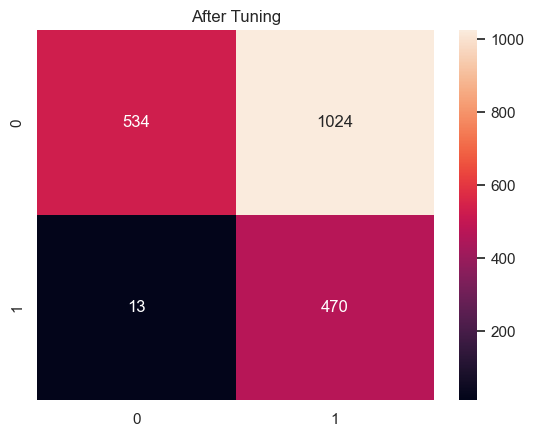

In [83]:
sns.heatmap(confusion_matrix(y_test, y_dummy), annot=True, fmt='.0f')
plt.title('After Tuning');

Insights:

- True Positive (TP): Ada 470 prediksi yang benar diklasifikasikan sebagai kelas positif.
- True Negative (TN): Ada 534 prediksi yang benar diklasifikasikan sebagai kelas negatif.
- False Positive (FP): Ada 1024 prediksi yang salah diklasififkasikan sebagai kelas positif.
- False Negative (FN): Ada 13 prediksi yang salah diklasifikasikan sebagai kelas negatif.

Dari confusion matrix tersebut, dapat ditarik beberapa kesimpulan:

- Dengan proporsi threshold 0.48 menggunakan Logistic Regression model, model berhasil mengklasifikasikan 470 sampel sebagai kelas positif yang benar dan 534 sampel sebagai kelas negatif yang benar
- Model salah mengklasifikasikan 1024 sampel sebagai kelas positif padahal seharusnya kelas negatif.
- Model juga salah mengklasifikasikan 13 sampel kelas negatif padahal seharusnya positif.

## **Feature Importance**

**Mengambil feature importance menggunakan nilai coeffision**

In [84]:
importance = best_model[2].coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.24588
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.37625
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: -0.00518
Feature: 25, Score: 0.00000
Feature: 26, Score: -0.06868
Feature: 27, Score: -0.05421
Feature: 28, Score: 0.00694
Feature: 29, Score: -0.05243
Feature: 30, Score: 0.00000
Feature: 31, Score: -0.85106
Feature: 32, Score: -0.08735


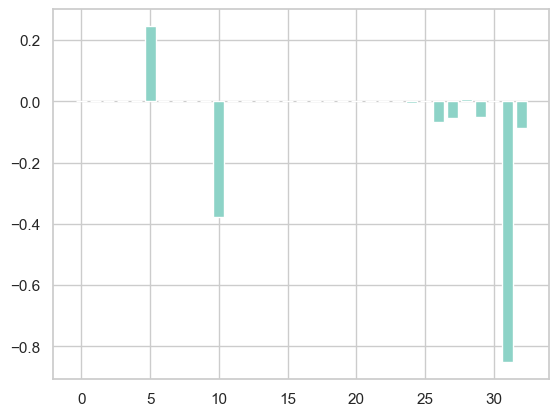

In [85]:
# membuat table untuk besaran nilai coeffision
plt.bar([x for x in range(len(importance))], importance)
plt.show()

**Mengambil nama kolom**

In [86]:
nama_pipe_1 = best_model[1].transformers_[0][1].get_feature_names_out()

In [87]:
nama_pipe_2 = best_model[1].transformers_[1][1].get_feature_names_out()

In [88]:
nama_pipe_3 = best_model[1].transformers_[2][2]

In [89]:
# menggabungkan nama feature

all_feature_1 = list(nama_pipe_1) + list(nama_pipe_2) + list(nama_pipe_3)

In [90]:
df_feat_importance = pd.DataFrame()
df_feat_importance['feature'] = all_feature_1
df_feat_importance['importance'] = importance
df_feat_importance=df_feat_importance.sort_values('importance', ascending=False)
df_feat_importance

,feature,importance
5,market_segment_Online TA,0.245880
28,previous_cancellations,0.006938
0,market_segment_Complementary,0.000000
15,reserved_room_type_F,0.000000
30,days_in_waiting_list,0.000000
25,0_5,0.000000
23,0_3,0.000000
22,0_2,0.000000
21,0_1,0.000000
20,0_0,0.000000


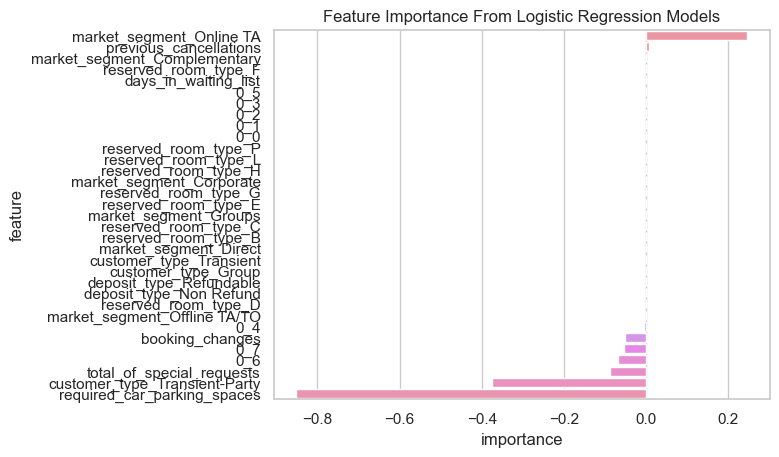

In [91]:
sns.barplot(
    data=df_feat_importance,
    x='importance',
    y='feature'
)
plt.title('Feature Importance From Logistic Regression Models')
plt.show()

Insight:<br><br>
Tabel "feature importance" menampilkan tingkat pentingnya setiap fitur dalam model. Interpretasi singkat dari tabel:

1. Fitur yang paling penting dalam model adalah 'required_car_parking_spaces' dengan nilai penting sebesar -0,85. Ini menunjukkan bahwa fitur 'required_car_parking_spaces' memiliki kontribusi paling signifikan dalam mempengaruhi prediksi hasil model. Perubahan dalam fitur ini akan memiliki dampak yang besar terhadap prediksi yang dihasilkan oleh model.

2. Fitur-fitur lain juga memiliki kontribusi yang cukup tinggi dalam model adalah 'customer_type_Transient-Party', 'total_of_special_requests', dan 'market_segment_Online'. Hal ini menunjukkan bahwa fitur-fitur tersebut memiliki pengaruh yang signifikan terhadap hasil prediksi.

3. Ada beberapa fitur yang memiliki nilai 0.0, yang menunjukkan bahwa fitur-fitur ini tidak memberikan kontribusi apa pun dalam model dan mungkin bisa dihapus dari model karena tidak memberikan informasi yang berguna untuk prediksi.

Interpretasi singkat dari tabel "feature importance" ini membantu untuk memahami peran relatif setiap fitur dalam model dan memperoleh wawasan tentang faktor-faktor yang paling berpengaruh dalam melakukan prediksi.

## **Koefisien**

Ada beberapa fitur yang tidak bisa kita interpretasikan yaitu feature '0_4', '0_7', '0_6', feature-feature tersebut adalah feature hasil dari binary encoder yang sulit untuk kita interpretasikan. Maka dari itu kita tidak menginterpretasikannya.

In [92]:
# untuk mencari c dan d
X_train_log.describe().loc[['min', 'max']]

,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.107538,-0.615384,-0.155723,-0.423174,-0.903243
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,32.489598,15.488623,17.381656,19.626312,3.932342


In [93]:
X_train.describe(include='all').loc[['mean', 'std']]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests
mean,NaN,NaN,0.085774,0.802475,NaN,3.471878,NaN,NaN,0.168852,0.933954
std,NaN,NaN,0.797665,1.304103,NaN,22.296602,NaN,NaN,0.399037,1.034064


### **Odd ratio untuk feature-feature terpilih**

**Odd ratio market_segment_online TA**

In [94]:
c = 1
d = 0
beta = 0.245880

odd_ratio_market = np.exp(beta * (c-d))
odd_ratio_market

1.2787461148006218

Customer yang berasal dari market segment online TA peluang cancelnya adalah 1.27 kalinya dari customer yang bukan berasal dari market segment online TA.

**Odd ratio booking_changes**

In [95]:
c = 0.2
d = 0.1
beta = -0.052434

odd_ratio_booking = np.exp(beta * (c-d))
odd_ratio_booking

0.9947703226268964

In [96]:
# mengembalikan ke nilai awal (scaled = x - mean / std)

x = (0.2 * 1.304103) + 0.802475
x

1.0632956

In [97]:
# mengembalikan ke nilai awal (scaled = x - mean / std)

x = (0.1 * 1.304103) + 0.802475
x

0.9328853

Customer yang mengganti booking sebanyak 1.06 kali peluang cancelnya adalah 0.994 kalinya dari customer yang mengganti booking 0.93 kali

**Odd ratio total_of_special_request**

In [98]:
c = 0.2
d = 0.1
beta = -0.087349

odd_ratio_booking = np.exp(beta * (c-d))
odd_ratio_booking

0.9913031384045466

In [99]:
# mengembalikan ke nilai awal (scaled = x - mean / std)

x = (0.2 * 1.034064) + 0.933954
x

1.1407668

In [100]:
# mengembalikan ke nilai awal (scaled = x - mean / std)

x = (0.1 * 1.034064) + 0.933954
x

1.0373603999999998

Customer yang total of special request-nya 1.14 peluang cancelnya adalah 0.916 kalinya dari customer yang total of special request-nya 1.037

**Odd ratio required_car_parking_spaces**

In [101]:
c = 0.2
d = 0.1
beta = -0.851060

odd_ratio_booking = np.exp(beta * (c-d))
odd_ratio_booking

0.9184149272593305

In [102]:
# mengembalikan ke nilai awal (scaled = x - mean / std)

x = (0.2 * 0.399037) + 0.168852
x

0.2486594

In [103]:
# mengembalikan ke nilai awal (scaled = x - mean / std)

x = (0.1 * 0.399037) + 0.168852
x

0.2087557

Customer yang required car parking spaces sebanyak 0.24 peluang cancelnya adalah 0.918 kalinya dari customer yang required car parking spaces sebanyak 0.208

**Odd ratio previous_cancellations**

In [104]:
c = 0.2
d = 0.1
beta = 0.006938

odd_ratio_booking = np.exp(beta * (c-d))
odd_ratio_booking

1.0006940407348908

In [105]:
# mengembalikan ke nilai awal (scaled = x - mean / std)

x = (0.2 * 0.797665) + 0.085774
x

0.245307

In [106]:
# mengembalikan ke nilai awal (scaled = x - mean / std)

x = (0.1 * 0.797665) + 0.085774
x

0.1655405

Customer yang previous cancelation sebanyak 0.245 kali peluang cancelnya adalah 1.000 kalinya dari customer yang previous cancellations 0.165

## **Kesimpulan dan Rekomendasi**

### **Kesimpulan**

Berdasarkan hasil evaluasi, dapat disimpulkan bahwa:

- Dalam proses cross validation untuk pemilihan algoritma terbaik, kami memilih pendekatan Logistic Regression.
- Dalam hyperparameter tuning, kita mendapatkan parameter-parameter terbaik, yaitu:
    1. Parameter C pada logistic regression -> 0.01
    2. Parameter penalty logistic regression -> 'l1'
    3. Parameter solver pada logistic regression -> 'liblinear'
    4. Scaler terbaik -> Standard scaler
    5. Resampling terbaik -> RandomUnderSampler
- Kinerja model setelah tuning mengalami peningkatan dari 79.3% menjadi 93.58% pada recall score,kami menggunakan model setelah tuning karena memiliki tingkat recall yang lebih tinggi

In [107]:
print(classification_report(y_test, y_dummy))

              precision    recall  f1-score   support

           0       0.98      0.34      0.51      1558
           1       0.31      0.97      0.48       483

    accuracy                           0.49      2041
   macro avg       0.65      0.66      0.49      2041
weighted avg       0.82      0.49      0.50      2041



Classification report yang akan menjadi final model adalah yang di tuning seperti diatas, dan menurut clasification report diatas bahwa model ini akan digunakan oleh hotel baik bagian marketing ataupun management untuk memprediksi terjadinya cancelation dari customer. Dan berdasarkan model ini menunjukkan bahwa:

1. Dari seluruh customer yang akan cancel maka sekitar sekitar 97% diprediksi dengan benar menggunakan model ini. hal ini bisa dilihat dari recallnya pada target 1 (cancel), dan model juga dapat menebak dengan benar untuk customer yang tidak melakukan cancel sebesar 34% dari seluruh customer yang memang tidak cancel, hal ini juga dilihat dari recall target 0 (tidak cancel).

2. Dari seluruh prediksi cancel dari model, model dapat mengidentifikasi sekitar 31% ketepatan prediksi target 1 (cancel) hal ini diambil dari precisionnya, dan dari seluruh prediksi tidak akan cancel akan diindentifikasi benar oleh model sekitar 98% pada target 0 (tidak cancel).

In [108]:
array = np.array([[y_test.value_counts()[0],0],
                  [y_test.value_counts()[1],0]
                  ])

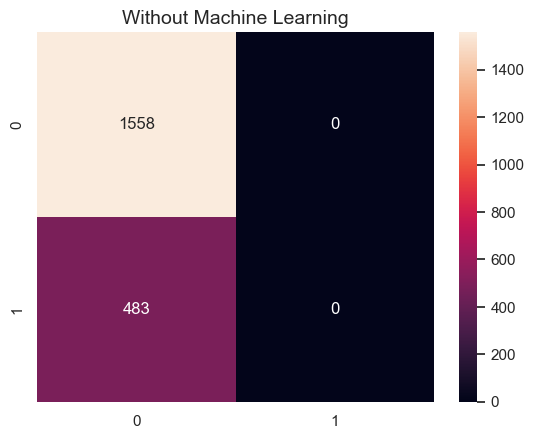

In [114]:
sns.heatmap(data=array, annot=True, fmt='.0f')
plt.title('Without Machine Learning', size=14);

***Membandingkan kinerja tanpa machine learning, dan dengan machine learning***

Disini kita ingin melihat kerugian sebelum dan sesudah menggunakan machine learning.<br>
Rata-rata harga 1 malam di Portugal https://www.budgetyourtrip.com/hotels/portugal-PT<br>
Besaran diskon untuk last minute sell https://www.nerdwallet.com/article/travel/is-it-cheaper-to-book-hotel-last-minute

**Tanpa machine learning**<br><br>
Kita menggunakan jumlah customer pada test data, dimana:<br>
1558 customer tidak akan cancel<br>
483 customer akan cancel
<br><br>
1. Total estimasi revenue -> 2041 customer x $100 = $204.100<br>
2. Customer yg akan cancel -> 483 customer x $100 = $48.300 <br><br>
Total loss revenue = **$48.300**

Nett profit = $204.100 - $48.300 = **$155.800**

**Dengan machine learning**<br><br>

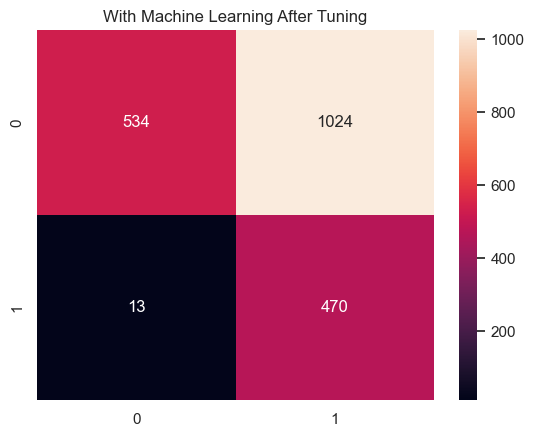

In [110]:
sns.heatmap(confusion_matrix(y_test, y_dummy), annot=True, fmt='.0f')
plt.title('With Machine Learning After Tuning');

Kita menggunakan jumlah customer pada data set terbaik yang sudah kita tuning.<br>
470 --> TP<br>
1024 --> FP<br>
534 --> TN<br>
13 --> FN<br>

1. Total estimasi revenue -> 2041 customer x $100 = $204.100<br>
2. Total customer yang salah prediksi menginap (FN) -> 13 customer x $100 = $1.300 <br>
3. Total customer yang salah prediksi tidak menginap (FP) -> 1024 x $13 = $13.312<br>

Total loss revenue = $1.300 + $13.312 = **$14.612**

Nett profit = $204.100 - $14.612 = **$189.488**

**Konklusi dari perbandingan**

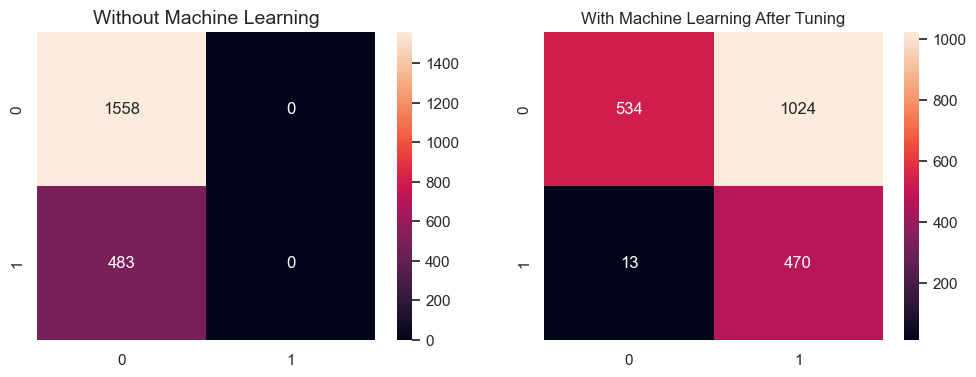

In [116]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.heatmap(data=array, annot=True, fmt='.0f')
plt.title('Without Machine Learning', size=14);

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_dummy), annot=True, fmt='.0f')
plt.title('With Machine Learning After Tuning');

| Perhitungan | Tanpa model | Dengan model |
| --- | --- | --- |
| Total Revenue Loss | $48.300 | $14.612 |
| Net Profit | $155.800 | $189.488 |

Jika dilihat pada tabel diatas, kita sudha berhasil untuk membuat model yang sangat berpengaruh signifikan terhadap hotel. 

Kita berhasil untuk menurunkan total revenue loss hotel dari yang sebelumnya $48.300, dengan model total revenue loss nya menjadi $14.612.

Dan kita juga berhasil untuk meningkatkan pendapatan hotel sebesar 21% dari yang sebelumnya hanya $155.800 menjadi $189.488.

### **Rekomendasi**

**Rekomendasi untuk model**

- Bisa mencoba dengan algoritma lain yang bisa memberikan prediksi lebih baik atau mengubah penyetelan hyperparameter pada model saat ini secara rutin. Karena kita membuat model ini dengan mengasumsikan bahwa sedang on season yang dimana hotel full booked.

- Menambahkan feature atau kolom baru yang terkait dengan informasi tamu, seperti riwayat waktu reservasi, detail komplain customer, dan sebagainya untuk bisa meningkatkan model agar model memiliki performa yang lebih akurat.

- Improvement of data quality, dimana kualitas data masih kurang maksimal (melihat duplicate data mencapai 70% data), sehingga cara untuk membersihkan data dengan cara drop duplicate. Dikarenakan kita ingin menghindari overfitting pada data yang memiliki jumlah duplicate yang banyak.

**Rekomendasi untuk bisnis**

- Pihak hotel harus segera merevisi kebijakan pembatalan pemesanan hotel, melihat banyak customer yang berasal dari portugal (tempat hotel berada) melakukan pembatalan pemesanan.

- Pihak hotel juga harus secara teratur melakukan follow up ke customer yang sudah melakukan booking pemesanan, hal ini dilakukan supaya untuk menjadi remainder customer bahwa customer sudah melakukan booking pada hotel kita dan supaya bisa menjaga nama baik hotel kita.

- Divisi marketing juga harus terus melakukan promo kepada customer yang membayar penuh atau tidak sesuai sesuai dengan prediksi apakah customer tersebut membatalkan pesanan atau tidak. Dengan begitu, hotel bisa memfokuskan pelayanannya bagi customer yang potensial dan tidak rugi dikarenakan memberikan promo kepada customer yang salah.

## **Save Final Model**

In [112]:
import pickle

In [113]:
# best model
logreg_tuning = gridsearch.best_estimator_

# fit
logreg_tuning.fit(X, y)

# save with pickle
pickle.dump(logreg_tuning, open('model_logreg.sav', 'wb'))